In [ ]:
from typing import List, Optional, Tuple, Dict, Any
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import Lasso
from google.colab import drive
import numpy as np
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
from typing import Tuple, List, Union

def train_test_split_time(
    X: pd.DataFrame,
    y: pd.Series,
    q: float,
    col: str,
    drop_col : bool = True
) -> Tuple[pd.DataFrame, pd.DataFrame, pd.Series, pd.Series]:
    """
    Splits feature (X) and target (y) DataFrames/Series into train and test sets
    based on the time column values in X. The split is determined by a ratio 'q'.

    The first 'q' ratio of *unique* time values from the specified column are
    used for the train set, and the remaining are used for the test set.

    Args:
        X: The input pandas DataFrame containing features and the time column.
        y: The input pandas Series containing the target variable.
        q: A float between 0 and 1 specifying the ratio of unique time values
           to allocate to the training set.
        col: The name of the time column in X to use for splitting.

    Returns:
        A tuple containing the four split segments: (X_train, X_test, y_train, y_test).

    Raises:
        KeyError: If the specified column 'col' is not found in X.
        ValueError: If 'q' is not between 0 and 1, or if X and y do not have matching indices.
    """
    if col not in X.columns:
        raise KeyError(f"Column '{col}' not found in the features DataFrame X.")

    if len(X) != len(y) or not (X.index.equals(y.index)):
         raise ValueError("X and y must have the same length and matching indices.")

    if not (0 < q < 1):
        raise ValueError(f"q ({q}) must be strictly between 0 and 1.")

    # Get sorted unique time values
    unique_times = X[col].sort_values().unique()
    num_unique_times = len(unique_times)

    # Calculate the number of unique time values for the training set
    # The split index must be an integer, so we use floor or round.
    # We use floor to ensure the ratio q is respected (or slightly less).
    train_n_unique = int(np.floor(q * num_unique_times))

    # Check if the calculated split is valid (must have at least one unique time in train)
    if train_n_unique < 1:
        # This will only happen if q is extremely small and num_unique_times is small.
        raise ValueError("Calculated train set size is zero. Please increase q or provide more unique time values.")

    # Determine the *value* of the split point
    # We use index [train_n_unique - 1] because we want the first N unique values
    # and Python indexing is 0-based.
    train_time_limit = unique_times[train_n_unique - 1]

    # Create a boolean mask for the split
    train_mask = X[col] <= train_time_limit

    # Split the DataFrames/Series
    X_train = X.drop(columns=[col])[train_mask]
    X_test = X.drop(columns=[col])[~train_mask]

    y_train = y.drop(columns=[col])[train_mask]
    y_test = y.drop(columns=[col])[~train_mask]

    return X_train.values, X_test.values, np.squeeze(y_train.values), np.squeeze(y_test.values), X[col][train_mask].values, X[col][~train_mask].values

In [ ]:
def train_model(
    df: pd.DataFrame,
    target_col: str,
    feature_cols: List[str],
    model=None,                           # Any sklearn regressor/classifier
    test_size: float = 0.2,
    random_state: int = 42,
    scale: bool = True,                   # Whether to apply StandardScaler
    model_params: Optional[Dict[str, Any]] = None,
):
    """
    Train a model (default: Lasso) on selected features of a DataFrame.

    Parameters
    ----------
    df : pd.DataFrame
        The dataset.
    target_col : str
        Column name for the target variable.
    feature_cols : List[str]
        List of column names to use as features.
    model : sklearn estimator, optional
        Model to train. Default is sklearn Lasso.
    test_size : float, optional
        Fraction of data to use for testing.
    random_state : int, optional
        Random seed for reproducibility.
    scale : bool, optional
        Whether to scale features with StandardScaler.
    model_params : dict, optional
        Parameters passed to the model constructor.

    Returns
    -------
    dict
        {
            "model": fitted_model,
            "X_train": X_train,
            "X_test": X_test,
            "y_train": y_train,
            "y_test": y_test,
            "y_pred": predictions,
            "metrics": {...}
        }
    """

    # Extract X and y
    X = df[feature_cols]
    y = df[target_col]

    # Default model = Lasso
    if model is None:
        model = Lasso

    if model_params is None:
        model_params = {}

    # Build pipeline
    steps = []
    if scale:
        steps.append(("scaler", StandardScaler()))
    steps.append(("model", model(**model_params)))

    pipeline = Pipeline(steps)

    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y,
        test_size=test_size,
        random_state=random_state
    )

    # Fit
    pipeline.fit(X_train, y_train)

    # Predict
    y_pred = pipeline.predict(X_test)

    # Metrics (regression)
    metrics = {
        "mse": mean_squared_error(y_test, y_pred),
        "r2": r2_score(y_test, y_pred)
    }

    return {
        "model": pipeline,
        "X_train": X_train,
        "X_test": X_test,
        "y_train": y_train,
        "y_test": y_test,
        "y_pred": y_pred,
        "metrics": metrics
    }


In [ ]:
!ls /content/drive/MyDrive/STA221\ Data

Adams_Testing_Notebook.ipynb		    fpl_data.csv
all_match_data.csv			    merged_fpl_dataset.csv
beautiful_fpl_data.csv			    player_name_mapping_review.csv
EDA_feature_importance_finaldata.ipynb	    Sta221FinalData.ipynb
final_dataset.csv			    TotalPointsRegression.ipynb
final_dataset_with_teams_and_opponents.csv  vaastav-gw-data-merged-1.csv
final_dataset_with_teams.csv		    vaastav-gw-data-merged-2.csv
fixtures.csv


In [ ]:
!ls /content/drive/MyDrive/STA221\ Data/*.csv

'/content/drive/MyDrive/STA221 Data/all_match_data.csv'
'/content/drive/MyDrive/STA221 Data/beautiful_fpl_data.csv'
'/content/drive/MyDrive/STA221 Data/final_dataset.csv'
'/content/drive/MyDrive/STA221 Data/final_dataset_with_teams_and_opponents.csv'
'/content/drive/MyDrive/STA221 Data/final_dataset_with_teams.csv'
'/content/drive/MyDrive/STA221 Data/fixtures.csv'
'/content/drive/MyDrive/STA221 Data/fpl_data.csv'
'/content/drive/MyDrive/STA221 Data/merged_fpl_dataset.csv'
'/content/drive/MyDrive/STA221 Data/player_name_mapping_review.csv'
'/content/drive/MyDrive/STA221 Data/vaastav-gw-data-merged-1.csv'
'/content/drive/MyDrive/STA221 Data/vaastav-gw-data-merged-2.csv'


In [ ]:
dataset = pd.read_csv('/content/drive/MyDrive/STA221 Data/final_dataset_with_teams_and_opponents.csv', index_col=0)
print(dataset.shape, dataset.target_minutes.value_counts())
#Keeping only X 0 minute rows
NUM_0_MINS_TO_KEEP = 0
dataset = pd.concat([
    dataset[dataset.target_minutes == 0].head(NUM_0_MINS_TO_KEEP),
    dataset[dataset.target_minutes != 0]
]).sort_index()
print(dataset.shape, dataset.target_minutes.value_counts())

meta = [x for x in dataset.columns if x.startswith('meta_')]
all_targets = [x for x in dataset.columns if x.startswith('target_')]
features = [x for x in dataset.columns if x.startswith('feature_')]
dataset['target_log_6p_total_points'] = np.log(6 + dataset.target_total_points)
target = 'target_total_points'
# target = 'target_log_6p_total_points'


(27605, 627) target_minutes
0     16039
90     5309
45      474
1       301
18      109
      ...  
43        3
46        2
44        2
42        2
47        1
Name: count, Length: 91, dtype: int64
(11566, 627) target_minutes
90    5309
45     474
1      301
18     109
71     108
      ... 
43       3
46       2
44       2
42       2
47       1
Name: count, Length: 90, dtype: int64


In [ ]:
dataset.meta_position.value_counts()

,count
meta_position,
MID,5738
DEF,3787
FWD,1271
GK,770


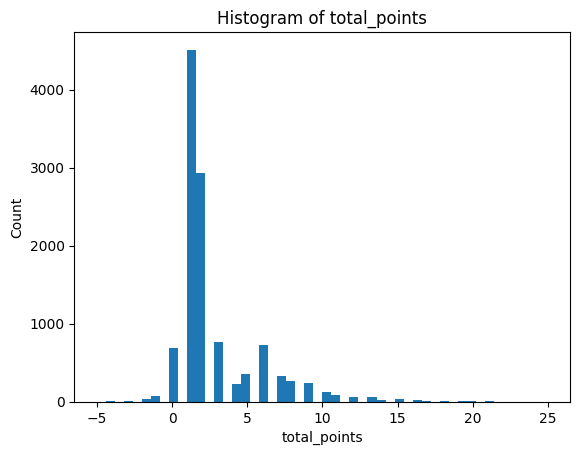

In [ ]:
import matplotlib.pyplot as plt

plt.hist(dataset.target_total_points, bins=50)
plt.xlabel('total_points')
plt.ylabel("Count")
plt.title(f"Histogram of total_points")
plt.show()

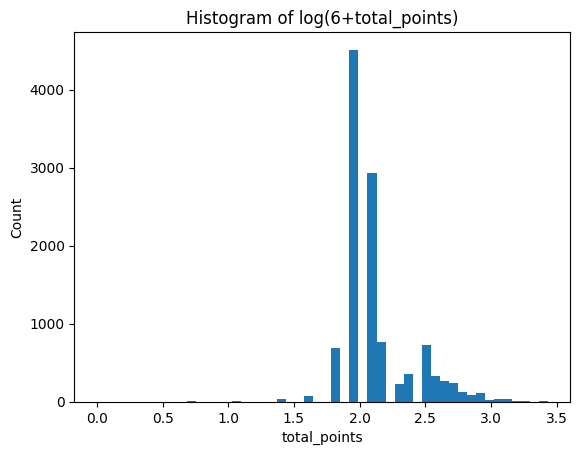

In [ ]:
import matplotlib.pyplot as plt

plt.hist(np.log(6+dataset.target_total_points), bins=50)
plt.xlabel('total_points')
plt.ylabel("Count")
plt.title(f"Histogram of log(6+total_points)")
plt.show()

In [ ]:
len(features), features

(476,
 ['feature_pregame_transfers_out',
  'feature_pregame_ict_index',
  'feature_pregame_selected',
  'feature_pregame_influence',
  'feature_pregame_creativity',
  'feature_pregame_threat',
  'feature_pregame_value',
  'feature_pregame_transfers_in',
  'feature_pregame_xP',
  'feature_goals_conceded_last_1000_days',
  'feature_expected_goals_last_1000_days',
  'feature_assists_last_1000_days',
  'feature_clean_sheets_last_1000_days',
  'feature_expected_assists_last_1000_days',
  'feature_expected_goals_conceded_last_1000_days',
  'feature_expected_goal_involvements_last_1000_days',
  'feature_goals_scored_last_1000_days',
  'feature_xAG_last_1000_days',
  'feature_Performance_Gls_last_1000_days',
  'feature_xA_last_1000_days',
  'feature_Aerial Duels_Won%_last_1000_days',
  'feature_Touches_Att Pen_last_1000_days',
  'feature_Touches_Live_last_1000_days',
  'feature_Performance_Crs_last_1000_days',
  'feature_Pass Types_CK_last_1000_days',
  'feature_Performance_Fls_last_1000_days'

In [ ]:
[col for col in dataset.columns if dataset[col].dtype == bool]

['meta_fixture_started',
 'meta_fixture_finished_provisional',
 'meta_fixture_provisional_start_time',
 'meta_was_home',
 'meta_fixture_finished',
 'feature_pregame_was_home']

In [ ]:
dataset[features].dtypes.value_counts().to_dict(), '=>', dataset[target].dtype

({dtype('float64'): 471, dtype('int64'): 4, dtype('bool'): 1},
 '=>',
 dtype('int64'))

In [ ]:
import pandas as pd
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
import numpy as np
from tqdm import tqdm

TOP_K = [5, 10, 15, 20, 30]

# ---- Define Models ----
models = {
    "LinearRegression": LinearRegression(),
    "Ridge": Ridge(alpha=1.0),
    "Lasso": Lasso(alpha=0.1),
    "ElasticNet": ElasticNet(alpha=0.1),
    # "RandomForest": RandomForestRegressor(n_estimators=200, n_jobs=-1),
    # "ExtraTrees": ExtraTreesRegressor(n_estimators=200, n_jobs=-1),
    # "GradientBoosting": GradientBoostingRegressor(),
    # "KNN": KNeighborsRegressor(n_neighbors=5),
    # "SVR": SVR(kernel="rbf")
}
scale_linear = True
# overall_binned = None
for position in dataset.meta_position.unique():
  subset = dataset[dataset.meta_position == position]
  print(f'FOR THE POSITION: {position}')
  X_train, X_test, y_train, y_test, GW_train, GW_test = train_test_split_time(
      subset[['meta_GW'] + features],
      subset[['meta_GW', target]],
      q=0.8, #Train on first 90% game weeks
      col='meta_GW',
      drop_col=True
  )
  print(f'Trained on: {np.unique(GW_train)}\nTested on: {np.unique(GW_test)}')
  unique_test_GW = np.unique(GW_test)
  print(unique_test_GW)
  for name, model in tqdm(models.items()):
    # scale linear-like models; skip trees
    if scale_linear and name in ["LinearRegression", "Ridge", "Lasso", "ElasticNet", "SVR", "KNN"]:
        pipe = Pipeline([
            ("scaler", StandardScaler()),
            ("model", model)
        ])
        pipe.fit(X_train, y_train)
        y_pred = pipe.predict(X_test)
    else:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

    # print(f'MSE: {mean_squared_error(y_test, y_pred)}')

    rank_mse = []
    mse = []
    top_k_rank_mse = {k:[] for k in TOP_K}
    for gw in unique_test_GW:
      gw_mask = (GW_test == gw)

      gw_true = y_test[gw_mask]
      gw_true_rank = gw_true.argsort().argsort() #Double argsort makes each index the position that element would be in the sorted array

      gw_pred = y_pred[gw_mask]
      gw_pred_rank = gw_pred.argsort().argsort()

      #Rank MSE is also a bad metric
      # make a new metric that says: How many of the models top 20 were in the real top 20
      rank_mse.append(mean_squared_error(gw_true_rank, gw_pred_rank))
      mse.append(mean_squared_error(gw_true, gw_pred))
      # print(f'Ranked positional MSE for GW {gw}: {mean_squared_error(gw_true_rank, gw_pred_rank)}')
      # print(f'MSE for GW {gw}: {mean_squared_error(gw_true, gw_pred)}')

      for k in filter(lambda _k: _k <= gw_true.shape[0], TOP_K):
          # get the indices of top-k highest values in gw_true
          topk_idx = np.argpartition(gw_true, -k)[-k:]   # unordered
          # OPTIONAL: sort them descending for consistency
          topk_idx = topk_idx[np.argsort(gw_true[topk_idx])[::-1]]
          # compute MSE only over those indices
          mse_k = mean_squared_error(gw_true[topk_idx], gw_pred[topk_idx])
          top_k_rank_mse[k].append(mse_k)


    top_k_rank_mse_mean = {x:np.array(y).mean() if len(y) > 0 else 'NoValues' for (x,y) in top_k_rank_mse.items()}
    print(f'\nModel: {name}:\n\tweekwise avg,std rank mse: {np.array(rank_mse).mean()},{np.array(rank_mse).std()}\n\tweekwise avg mse: {np.array(mse).mean()}')
    print(f'top-k rank mse: {top_k_rank_mse_mean}')

  # print(y_test.shape)
  # results_df, binned = evaluate_models(X_train, X_test, y_train, y_test)
  # print(f'Results for {position}:', results_df, sep='\n')
  # for i, x in enumerate(binned):
  #   binned[i]['position'] = position
  # overall_binned = pd.concat(([overall_binned] if overall_binned is not None else []) + binned)
  # print(pd.concat(binned))
  # print('\n\n')
# overall_binned.groupby(['bin', 'position'])['MSE'].min()

FOR THE POSITION: MID
Trained on: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30]
Tested on: [31 32 33 34 35 36 37 38]
[31 32 33 34 35 36 37 38]


 25%|██▌       | 1/4 [00:01<00:05,  1.72s/it]


Model: LinearRegression:
	weekwise avg,std rank mse: 1443.8664233800414,297.7766713731365
	weekwise avg mse: 2.2138065656306116
top-k rank mse: {5: np.float64(11.299773433321871), 10: np.float64(7.571769186065286), 15: np.float64(6.680265000449231), 20: np.float64(5.817725467569074), 30: np.float64(5.559902805677942)}


 50%|█████     | 2/4 [00:02<00:02,  1.30s/it]


Model: Ridge:
	weekwise avg,std rank mse: 1385.929341207368,273.6050342611767
	weekwise avg mse: 2.045760606044607
top-k rank mse: {5: np.float64(10.643853551946084), 10: np.float64(7.287364472877781), 15: np.float64(6.339382492086823), 20: np.float64(5.506205880524889), 30: np.float64(5.192596150886985)}


 75%|███████▌  | 3/4 [00:03<00:00,  1.06it/s]


Model: Lasso:
	weekwise avg,std rank mse: 1083.9760485431386,217.26804039460234
	weekwise avg mse: 1.438551861806618
top-k rank mse: {5: np.float64(9.0932790171574), 10: np.float64(6.709360647572636), 15: np.float64(5.418633069624818), 20: np.float64(4.5109922975118275), 30: np.float64(3.6910451414428165)}


100%|██████████| 4/4 [00:03<00:00,  1.07it/s]


Model: ElasticNet:
	weekwise avg,std rank mse: 1080.8254795262794,211.57220487868392
	weekwise avg mse: 1.4905102568488673
top-k rank mse: {5: np.float64(10.216327063239145), 10: np.float64(7.416843044495311), 15: np.float64(6.017862718567937), 20: np.float64(4.968646575525515), 30: np.float64(4.068526175374858)}
FOR THE POSITION: DEF


Trained on: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30]
Tested on: [31 32 33 34 35 36 37 38]
[31 32 33 34 35 36 37 38]


 25%|██▌       | 1/4 [00:00<00:01,  2.97it/s]


Model: LinearRegression:
	weekwise avg,std rank mse: 1017.0539734302688,412.2536458832076
	weekwise avg mse: 10.084552997593782
top-k rank mse: {5: np.float64(47.46125624984487), 10: np.float64(37.13456392779915), 15: np.float64(31.365878823269497), 20: np.float64(27.28487917819283), 30: np.float64(21.7521980767703)}


 50%|█████     | 2/4 [00:00<00:00,  3.59it/s]


Model: Ridge:
	weekwise avg,std rank mse: 1007.3995690290209,443.54290768573014
	weekwise avg mse: 9.88757159557565
top-k rank mse: {5: np.float64(48.25007703516478), 10: np.float64(37.90673359155011), 15: np.float64(31.91072995179912), 20: np.float64(27.801973361039366), 30: np.float64(21.89337146712889)}


 75%|███████▌  | 3/4 [00:00<00:00,  3.92it/s]


Model: Lasso:
	weekwise avg,std rank mse: 856.5707314916572,329.7153233901723
	weekwise avg mse: 6.200096309903278
top-k rank mse: {5: np.float64(39.3546148461159), 10: np.float64(29.054080368678452), 15: np.float64(23.592687425689604), 20: np.float64(20.34866414658423), 30: np.float64(15.169992169187024)}


100%|██████████| 4/4 [00:01<00:00,  3.80it/s]



Model: ElasticNet:
	weekwise avg,std rank mse: 849.4376562276863,343.5167927633651
	weekwise avg mse: 6.296385298423772
top-k rank mse: {5: np.float64(40.76886832437357), 10: np.float64(29.761818294937), 15: np.float64(24.125766758432448), 20: np.float64(20.68121055014506), 30: np.float64(15.419346102688754)}
FOR THE POSITION: FWD
Trained on: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30]
Tested on: [31 32 33 34 35 36 37 38]
[31 32 33 34 35 36 37 38]


 50%|█████     | 2/4 [00:00<00:00,  6.98it/s]


Model: LinearRegression:
	weekwise avg,std rank mse: 68.32348777469377,25.59045019608862
	weekwise avg mse: 2.8645842899757508
top-k rank mse: {5: np.float64(5.169407689180317), 10: np.float64(4.317528131780417), 15: np.float64(3.6949990709226936), 20: np.float64(3.2563793430131507), 30: np.float64(2.9406827226239334)}

Model: Ridge:
	weekwise avg,std rank mse: 70.7832010463836,23.28011757120535
	weekwise avg mse: 2.012044005773445
top-k rank mse: {5: np.float64(4.005791986366001), 10: np.float64(3.3239870604935193), 15: np.float64(2.8577729855999756), 20: np.float64(2.445843801727536), 30: np.float64(2.1051879886991673)}


100%|██████████| 4/4 [00:00<00:00,  6.73it/s]


Model: Lasso:
	weekwise avg,std rank mse: 59.71237752271366,26.739564571619944
	weekwise avg mse: 0.9063398478997233
top-k rank mse: {5: np.float64(2.441317021459821), 10: np.float64(1.6703236112142166), 15: np.float64(1.4269069731086397), 20: np.float64(1.1549105026385904), 30: np.float64(0.949717412485626)}

Model: ElasticNet:
	weekwise avg,std rank mse: 56.131913761591655,20.893522058017364
	weekwise avg mse: 0.9734464606125868
top-k rank mse: {5: np.float64(2.628956720961028), 10: np.float64(1.7578398628995477), 15: np.float64(1.5362594866177133), 20: np.float64(1.2458273186474633), 30: np.float64(1.0091581680989476)}
FOR THE POSITION: GK


Trained on: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30]
Tested on: [31 32 33 34 35 36 37 38]
[31 32 33 34 35 36 37 38]


 25%|██▌       | 1/4 [00:00<00:00,  3.49it/s]


Model: LinearRegression:
	weekwise avg,std rank mse: 56.827816205533594,28.265627584582244
	weekwise avg mse: 30.901089337940668
top-k rank mse: {5: np.float64(66.05869064367671), 10: np.float64(43.63043465210397), 15: np.float64(37.11757195296582), 20: np.float64(33.201875794037555), 30: 'NoValues'}


100%|██████████| 4/4 [00:00<00:00,  5.11it/s]


Model: Ridge:
	weekwise avg,std rank mse: 49.13983036890646,20.51595883696012
	weekwise avg mse: 16.275429051816914
top-k rank mse: {5: np.float64(42.22470846052663), 10: np.float64(25.22361271041137), 15: np.float64(20.559662373354257), 20: np.float64(16.682704843335987), 30: 'NoValues'}

Model: Lasso:
	weekwise avg,std rank mse: 37.60562417654809,19.91041387751512
	weekwise avg mse: 8.780014635708184
top-k rank mse: {5: np.float64(26.571511604543936), 10: np.float64(14.597853982145836), 15: np.float64(10.449470105804597), 20: np.float64(7.200847392252002), 30: 'NoValues'}

Model: ElasticNet:
	weekwise avg,std rank mse: 39.722529644268775,19.19795273101993
	weekwise avg mse: 8.7308805131395
top-k rank mse: {5: np.float64(26.078209764517798), 10: np.float64(14.358291517681423), 15: np.float64(10.346963135900804), 20: np.float64(7.1892481687507255), 30: 'NoValues'}


In [ ]:
import numpy as np
from sklearn.ensemble import GradientBoostingRegressor

# Example: weight proportional to target
weights = np.clip(y_train, a_min=4, a_max=None)  # give higher weight to bigger y
model = GradientBoostingRegressor()
model.fit(X_train, y_train, sample_weight=weights)
y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(mse, r2)

11.620005374967517 -0.296011735834919


In [ ]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error

def mse_per_target_bin(y_test, y_pred, num_bins=5, bin_type='quantile'):
    """
    Compute Mean Squared Error per bin of target values, robust to duplicate bin edges.
    """
    y_test = np.array(y_test)
    y_pred = np.array(y_pred)

    # Determine bins
    if bin_type == 'quantile':
        bins = np.unique(np.quantile(y_test, np.linspace(0, 1, num_bins + 1)))
    elif bin_type == 'uniform':
        bins = np.unique(np.linspace(-20, 60, num_bins + 1))
    else:
        raise ValueError("bin_type must be 'quantile' or 'uniform'")

    if len(bins) - 1 == 0:
        raise ValueError("Not enough unique values to create bins.")

    # Create bin labels
    bin_labels = [f"{bins[i]:.2f}-{bins[i+1]:.2f}" for i in range(len(bins)-1)]

    # Assign each value to a bin
    bin_indices = pd.cut(y_test, bins=bins, labels=bin_labels, include_lowest=True)

    # DataFrame for convenience
    df = pd.DataFrame({'y_test': y_test, 'y_pred': y_pred, 'bin': bin_indices})

    # Compute MSE per bin
    mse_per_bin = df.groupby('bin', observed=False).apply(lambda x: mean_squared_error(x['y_test'], x['y_pred']) if x['y_test'].shape[0] > 0 else 0.0, include_groups=False)
    mse_per_bin = mse_per_bin.rename("MSE").reset_index()

    return mse_per_bin


In [ ]:
mse_per_target_bin(y_test, y_pred)

,bin,MSE
0,0.00-1.00,9.948279
1,1.00-2.00,5.220978
2,2.00-3.00,1.295098
3,3.00-6.00,7.497248
4,6.00-15.00,41.813442


Outputs with team info (no opp info)

FOR THE POSITION: MID
Trained on: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34]
Tested on: [35 36 37 38]
[35 36 37 38]

 22%|██▏       | 2/9 [00:01<00:04,  1.61it/s]


Model: LinearRegression:
	weekwise avg,std rank mse: 2852.7012193671917,232.61217518576782
	weekwise avg mse: 7.988383580992489


Model: Ridge:
	weekwise avg,std rank mse: 2492.5844023661407,267.4215640696471
	weekwise avg mse: 6.668823118332293

 33%|███▎      | 3/9 [00:03<00:06,  1.07s/it]


Model: Lasso:
	weekwise avg,std rank mse: 2584.473690424334,210.96197304316405
	weekwise avg mse: 6.699305294034382

 44%|████▍     | 4/9 [00:06<00:09,  1.88s/it]


Model: ElasticNet:
	weekwise avg,std rank mse: 2571.6893286110117,225.15454351698824
	weekwise avg mse: 6.667294510695995

 56%|█████▌    | 5/9 [16:16<23:24, 351.05s/it]


Model: RandomForest:
	weekwise avg,std rank mse: 2602.1418012518825,275.9580518150765
	weekwise avg mse: 6.65785798851058

 67%|██████▋   | 6/9 [18:57<14:19, 286.35s/it]


Model: ExtraTrees:
	weekwise avg,std rank mse: 2575.36086576914,212.0578566966199
	weekwise avg mse: 6.6058367777266795

 78%|███████▊  | 7/9 [20:59<07:45, 232.85s/it]


Model: GradientBoosting:
	weekwise avg,std rank mse: 2618.9095050855112,144.69115524821825
	weekwise avg mse: 6.674072901675885

 89%|████████▉ | 8/9 [21:00<02:38, 158.82s/it]


Model: KNN:
	weekwise avg,std rank mse: 3241.7136112872363,384.1068102400758
	weekwise avg mse: 7.795091172326975

100%|██████████| 9/9 [21:15<00:00, 141.72s/it]


Model: SVR:
	weekwise avg,std rank mse: 2605.538648693122,206.58813173756107
	weekwise avg mse: 7.715130106933348

FOR THE POSITION: DEF
Trained on: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34]
Tested on: [35 36 37 38]
[35 36 37 38]

 22%|██▏       | 2/9 [00:00<00:01,  3.85it/s]


Model: LinearRegression:
	weekwise avg,std rank mse: 1665.167853415073,227.5868205205525
	weekwise avg mse: 10.982303913197741


Model: Ridge:
	weekwise avg,std rank mse: 1478.8582866290892,243.59679721405212
	weekwise avg mse: 9.136458642165401

 33%|███▎      | 3/9 [00:01<00:03,  1.97it/s]


Model: Lasso:
	weekwise avg,std rank mse: 1308.933232422549,178.3559736440183
	weekwise avg mse: 8.08678633913941

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.404e+01, tolerance: 2.525e+00
  model = cd_fast.enet_coordinate_descent(
 44%|████▍     | 4/9 [00:03<00:05,  1.10s/it]


Model: ElasticNet:
	weekwise avg,std rank mse: 1341.470730921644,187.78847443436263
	weekwise avg mse: 8.180058426231426

 56%|█████▌    | 5/9 [08:04<11:37, 174.37s/it]


Model: RandomForest:
	weekwise avg,std rank mse: 1427.3383936362688,160.17962976585545
	weekwise avg mse: 8.859621269472864

 67%|██████▋   | 6/9 [09:39<07:21, 147.21s/it]


Model: ExtraTrees:
	weekwise avg,std rank mse: 1322.4422469081353,233.22431751742138
	weekwise avg mse: 8.643316830110686

 78%|███████▊  | 7/9 [10:58<04:09, 124.93s/it]


Model: GradientBoosting:
	weekwise avg,std rank mse: 1433.0744119202232,201.11334434988487
	weekwise avg mse: 8.901516104371083


Model: KNN:
	weekwise avg,std rank mse: 1459.097989601812,125.73378530669066
	weekwise avg mse: 9.539425552813338

100%|██████████| 9/9 [11:05<00:00, 73.94s/it]


Model: SVR:
	weekwise avg,std rank mse: 1363.2679739008126,134.21224407162092
	weekwise avg mse: 9.480410903210089

FOR THE POSITION: FWD
Trained on: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34]
Tested on: [35 36 37 38]
[35 36 37 38]

 22%|██▏       | 2/9 [00:00<00:01,  5.98it/s]


Model: LinearRegression:
	weekwise avg,std rank mse: 154.74453740440458,16.664241159841946
	weekwise avg mse: 30.086446224187128


Model: Ridge:
	weekwise avg,std rank mse: 122.721421999885,23.03813730453643
	weekwise avg mse: 10.02599323019938

 33%|███▎      | 3/9 [00:00<00:01,  5.39it/s]


Model: Lasso:
	weekwise avg,std rank mse: 94.98510723937669,28.790457830516743
	weekwise avg mse: 8.39895285445888

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.611e+00, tolerance: 1.365e+00
  model = cd_fast.enet_coordinate_descent(
 44%|████▍     | 4/9 [00:01<00:01,  3.23it/s]


Model: ElasticNet:
	weekwise avg,std rank mse: 94.14179748145591,28.566972186975168
	weekwise avg mse: 8.39604542512847

 56%|█████▌    | 5/9 [02:30<03:35, 53.92s/it]


Model: RandomForest:
	weekwise avg,std rank mse: 108.38134667356678,21.98783042004786
	weekwise avg mse: 8.962051515223743

 67%|██████▋   | 6/9 [02:55<02:13, 44.39s/it]


Model: ExtraTrees:
	weekwise avg,std rank mse: 110.89822321890632,22.436508360172986
	weekwise avg mse: 9.161388973281012

 78%|███████▊  | 7/9 [03:27<01:20, 40.06s/it]


Model: GradientBoosting:
	weekwise avg,std rank mse: 120.62783911218445,18.915353040840696
	weekwise avg mse: 9.848853163002115


Model: KNN:
	weekwise avg,std rank mse: 125.57085561497325,12.59568323413004
	weekwise avg mse: 9.3209752170663

100%|██████████| 9/9 [03:27<00:00, 23.06s/it]


Model: SVR:
	weekwise avg,std rank mse: 99.68778391121845,18.379773737461207
	weekwise avg mse: 9.340387763507069

FOR THE POSITION: GK
Trained on: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34]
Tested on: [35 36 37 38]
[35 36 37 38]

 11%|█         | 1/9 [00:00<00:01,  5.15it/s]


Model: LinearRegression:
	weekwise avg,std rank mse: 60.22727272727273,18.00282691300186
	weekwise avg mse: 29.71057149367291


Model: Ridge:
	weekwise avg,std rank mse: 66.46363636363637,14.501563039152447
	weekwise avg mse: 7.758943406927539

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.614e+00, tolerance: 5.374e-01
  model = cd_fast.enet_coordinate_descent(
 33%|███▎      | 3/9 [00:00<00:01,  5.80it/s]


Model: Lasso:
	weekwise avg,std rank mse: 53.72954545454546,12.522248588442245
	weekwise avg mse: 6.22940131952793

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.502e+02, tolerance: 5.374e-01
  model = cd_fast.enet_coordinate_descent(
 44%|████▍     | 4/9 [00:00<00:00,  5.26it/s]


Model: ElasticNet:
	weekwise avg,std rank mse: 53.82954545454545,17.059611545236898
	weekwise avg mse: 6.210011229956506

 56%|█████▌    | 5/9 [01:07<01:28, 22.16s/it]


Model: RandomForest:
	weekwise avg,std rank mse: 71.67954545454546,13.883472210503921
	weekwise avg mse: 6.9947819050124895

 67%|██████▋   | 6/9 [01:22<00:59, 19.78s/it]


Model: ExtraTrees:
	weekwise avg,std rank mse: 71.11818181818181,13.980460094818406
	weekwise avg mse: 7.088076599478775

 78%|███████▊  | 7/9 [01:39<00:38, 19.05s/it]


Model: GradientBoosting:
	weekwise avg,std rank mse: 65.18181818181819,9.067178117157756
	weekwise avg mse: 6.809134831678308


Model: KNN:
	weekwise avg,std rank mse: 61.76136363636364,11.584508705255859
	weekwise avg mse: 7.829045454545454

100%|██████████| 9/9 [01:39<00:00, 11.09s/it]


Model: SVR:
	weekwise avg,std rank mse: 66.7840909090909,10.365231884757495
	weekwise avg mse: 7.723698882757823




Outputs with team and opponent info and also PCA

FOR THE POSITION: MID
Trained on: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34]
Tested on: [35 36 37 38]
[35 36 37 38]

 25%|██▌       | 1/4 [00:02<00:06,  2.09s/it]


Model: LinearRegression:
	weekwise avg,std rank mse: 1239.422896552789,118.90612379624797
	weekwise avg mse: 1.5760899896258582

 50%|█████     | 2/4 [00:02<00:02,  1.39s/it]


Model: Ridge:
	weekwise avg,std rank mse: 1215.4759923163274,114.77793888535236
	weekwise avg mse: 1.5427474217145334

 75%|███████▌  | 3/4 [00:03<00:01,  1.03s/it]


Model: Lasso:
	weekwise avg,std rank mse: 1065.5824078601672,36.395401561980165
	weekwise avg mse: 1.4530881911439737

100%|██████████| 4/4 [00:04<00:00,  1.04s/it]


Model: ElasticNet:
	weekwise avg,std rank mse: 1041.6875257901222,29.92510689431532
	weekwise avg mse: 1.4391896542109617

FOR THE POSITION: DEF


Trained on: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34]
Tested on: [35 36 37 38]
[35 36 37 38]

 25%|██▌       | 1/4 [00:00<00:01,  2.85it/s]


Model: LinearRegression:
	weekwise avg,std rank mse: 823.7752398132769,110.6785641210398
	weekwise avg mse: 5.323110363710638

 50%|█████     | 2/4 [00:00<00:00,  2.81it/s]


Model: Ridge:
	weekwise avg,std rank mse: 790.8544782847641,77.23012209453923
	weekwise avg mse: 5.0546136195033045

 75%|███████▌  | 3/4 [00:00<00:00,  3.22it/s]


Model: Lasso:
	weekwise avg,std rank mse: 694.0200846834642,105.51339134812685
	weekwise avg mse: 4.5225236532620485

100%|██████████| 4/4 [00:01<00:00,  3.22it/s]


Model: ElasticNet:
	weekwise avg,std rank mse: 678.6682253630169,127.01533490250863
	weekwise avg mse: 4.45995895794808

FOR THE POSITION: FWD
Trained on: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34]
Tested on: [35 36 37 38]
[35 36 37 38]

 50%|█████     | 2/4 [00:00<00:00,  7.24it/s]


Model: LinearRegression:
	weekwise avg,std rank mse: 69.83152205163591,21.837909018114544
	weekwise avg mse: 1.9139548362117602


Model: Ridge:
	weekwise avg,std rank mse: 73.17694497153701,19.861982478010653
	weekwise avg mse: 1.554473993224467

100%|██████████| 4/4 [00:00<00:00,  7.41it/s]


Model: Lasso:
	weekwise avg,std rank mse: 57.875927203726064,11.725312781326323
	weekwise avg mse: 0.8475868388891106


Model: ElasticNet:
	weekwise avg,std rank mse: 51.763814616755795,10.232996118915805
	weekwise avg mse: 0.8714490086100051

FOR THE POSITION: GK
Trained on: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34]
Tested on: [35 36 37 38]
[35 36 37 38]

 75%|███████▌  | 3/4 [00:00<00:00, 10.61it/s]


Model: LinearRegression:
	weekwise avg,std rank mse: 41.65681818181818,12.494513465338985
	weekwise avg mse: 10.410113980420242


Model: Ridge:
	weekwise avg,std rank mse: 41.09318181818182,11.433867293308582
	weekwise avg mse: 7.955358073291128


Model: Lasso:
	weekwise avg,std rank mse: 33.1,12.83179644476953
	weekwise avg mse: 4.921086354738563

100%|██████████| 4/4 [00:00<00:00, 10.59it/s]


Model: ElasticNet:
	weekwise avg,std rank mse: 36.29318181818182,14.921968350817862
	weekwise avg mse: 5.084374363879409

